## Auto-encoders

Jeu de donnée MNIST

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
((x_train, y_train), (x_test, y_test)) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(f'x_train shape before adding the "channels" dimension:{x_train.shape}')
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(f'x_train shape after adding the "channels" dimension:{x_train.shape}')
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

x_train shape before adding the "channels" dimension:(60000, 28, 28)
x_train shape after adding the "channels" dimension:(60000, 28, 28, 1)


In [13]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

# couche d'entrées
input_img = Input(shape=(28, 28, 1)) #img taille 28x28

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
z = MaxPooling2D((2, 2), padding='same')(x)


encoder = Model(input_img, z)

Decoder avec la couche UpSampling2D

In [14]:
from tensorflow.keras.layers import UpSampling2D

input_dec = Input(shape=(4, 4, 8))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_dec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_dec, decoded)


In [15]:
#Vérification de la taille
batch_size = 16
y = encoder.predict(x_train[:batch_size])
decoder.predict(y).shape

1/1 [==============================] - 0s 68ms/step


(16, 28, 28, 1)

In [16]:
auto_encoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

Training

In [17]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(x_train, x_train, epochs=25, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/25
469/469 [==============================] - 6s 7ms/step - loss: 0.2171 - val_loss: 0.1512
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1396 - val_loss: 0.1294
Epoch 3/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1255 - val_loss: 0.1205
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.1172 - val_loss: 0.1127
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1119 - val_loss: 0.1088
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1086 - val_loss: 0.1063
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1062 - val_loss: 0.1044
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.1045 - val_loss: 0.1029
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.1029 - val_loss: 0.1013
Epoch 10/25
469/469 [==============================] - 3s 7ms/step - loss: 0.1016 - val_loss: 0.100

In [18]:
z_test = encoder.predict(x_test)
y_pred = decoder.predict(z_test)
print(f'encodages z_test: {z_test.shape}')
print(f'décodages y_pred: {y_pred.shape}')

313/313 [==============================] - 1s 2ms/step
encodages z_test: (10000, 4, 4, 8)
décodages y_pred: (10000, 28, 28, 1)


Resultat de l'apprentissage

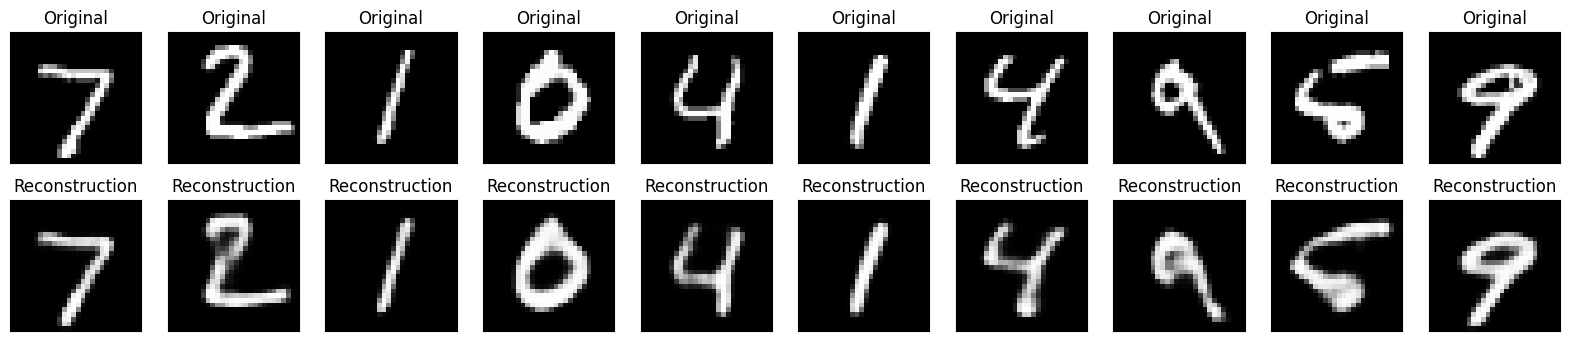

In [19]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(y_pred[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstruction')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

L'autoencodeur reconstitue bien l'image originale

**Application :** Debruitage 


In [20]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape) 
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Images avec bruit gaussien

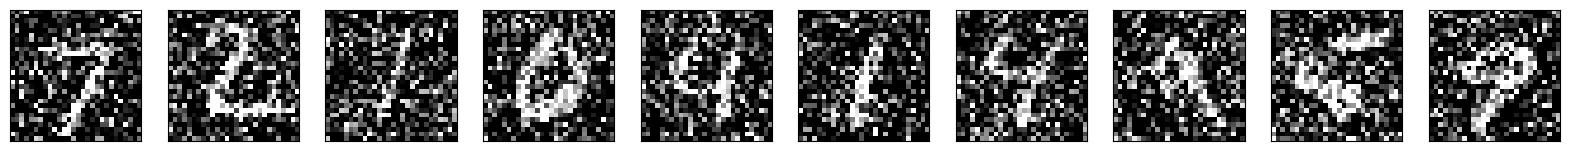

In [21]:
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Training

In [22]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 [==============================] - 7s 9ms/step - loss: 0.1461 - val_loss: 0.1327
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1317 - val_loss: 0.1284
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1286 - val_loss: 0.1261
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1267 - val_loss: 0.1243
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1251 - val_loss: 0.1231
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1241 - val_loss: 0.1220
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1232 - val_loss: 0.1214
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1225 - val_loss: 0.1210
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1219 - val_loss: 0.1202
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1214 - val_loss: 0.1196

313/313 [==============================] - 1s 2ms/step


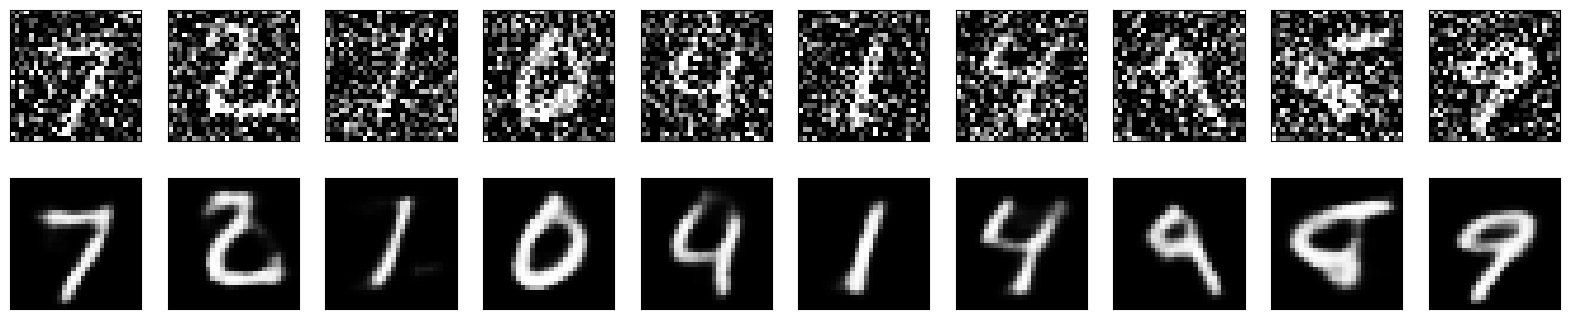

In [23]:
decoded_imgs = auto_encoder.predict(x_test_noisy)

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 [==============================] - 6s 7ms/step - loss: 0.1614 - val_loss: 0.1168
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1114 - val_loss: 0.1076
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1063 - val_loss: 0.1038
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1039 - val_loss: 0.1020
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1022 - val_loss: 0.1006
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1010 - val_loss: 0.0996
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1000 - val_loss: 0.0996
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0993 - val_loss: 0.0981
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0986 - val_loss: 0.0974
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0980 - val_loss: 0.0970

313/313 [==============================] - 1s 2ms/step


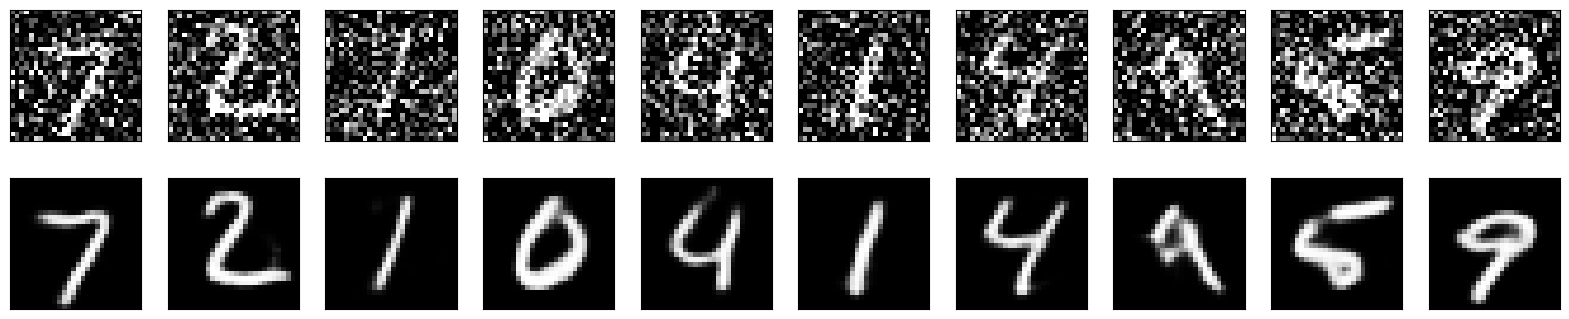

In [25]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## U-net
Utilisation de U-net pour recoloriser des images en noir et blanc du dataset "landscape" composé de 4000 images de paysages.  


In [26]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!mkdir landscapes
!unzip landscapes_small.zip -d landscapes
!rm -r landscapes/__MACOSX

--2023-04-27 07:35:26--  https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip [following]
--2023-04-27 07:35:26--  https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81935123 (78M) [application/zip]
Saving to: ‘landscapes_small.zip’

landscapes_small.zi 100%[===================>]  78.14M   222MB/s    in 0.4s 

Génération d'image noire et blanc


In [27]:
from keras.preprocessing.image import ImageDataGenerator

input_dir = 'landscapes'

seed = 1
 
color_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.1)
bw_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.1)
                                

train_color_generator = color_datagen.flow_from_directory(input_dir, class_mode=None, seed=seed, subset='training', target_size=(256, 256))
train_bw_generator = bw_datagen.flow_from_directory(input_dir, color_mode='grayscale', class_mode=None, seed=seed, subset='training', target_size=(256, 256))
valid_color_generator = color_datagen.flow_from_directory(input_dir, class_mode=None, seed=seed, subset='validation', target_size=(256, 256))
valid_bw_generator = bw_datagen.flow_from_directory(input_dir, color_mode='grayscale', class_mode=None, seed=seed, subset='validation', target_size=(256, 256))

train_generator = (pair for pair in zip(train_bw_generator, train_color_generator))
validation_generator = (pair for pair in zip(valid_bw_generator, valid_color_generator))

Found 3405 images belonging to 7 classes.
Found 3405 images belonging to 7 classes.
Found 376 images belonging to 7 classes.
Found 376 images belonging to 7 classes.


(32, 256, 256, 1) (32, 256, 256, 3)
0.0 1.0 0.0 1.0


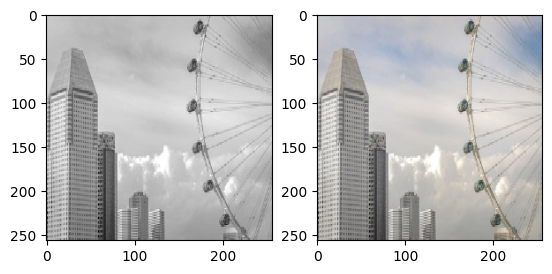

In [29]:
x, y = next(train_generator)
print(x.shape, y.shape)
print(x.min(), x.max(), y.min(), y.max())
 
fig, (ax1, ax2) = plt.subplots(1, 2)
idx = np.random.randint(0, len(x))
ax1.imshow(np.squeeze(x[idx], axis=-1), cmap='gray')
ax2.imshow(y[idx])

Schéma du réseaux U-net:
![](https://drive.google.com/uc?id=1F1uuhhRnXhV53aR1chU41Z17krRt2cuU)


In [32]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

def downsampling(input, filters):
    d = Conv2D(filters, kernel_size=4, strides=2, padding='same', activation='relu')(input)
    d = BatchNormalization()(d)
    return d


def upsampling(layer_input, skip_input, filters):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(u)
    u = BatchNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u

In [33]:
# Image input
d0 = Input(shape=(256, 256, 1))
 
# Downsampling
d1 = downsampling(d0, 32)
d2 = downsampling(d1, 64)
d3 = downsampling(d2, 128)
d4 = downsampling(d3, 256)
d5 = downsampling(d4, 256)
d6 = downsampling(d5, 256)
d7 = downsampling(d6, 256)
 
# Upsampling
u1 = upsampling(d7, d6, 256)
u2 = upsampling(u1, d5, 256)
u3 = upsampling(u2, d4, 256)
u4 = upsampling(u3, d3, 128)
u5 = upsampling(u4, d2, 64)
u6 = upsampling(u5, d1, 32)
# Last upsampling
u7 = UpSampling2D(size=2)(u6)
u7 = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u7)
 
model = Model(d0, u7)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
#fit
hist = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, validation_data=validation_generator, validation_steps=10)

Epoch 1/10


<ipython-input-33-88d274c25877>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, validation_data=validation_generator, validation_steps=10)


100/100 [==============================] - 63s 421ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0792 - val_loss: 0.0979 - val_mse: 0.0979 - val_mae: 0.2431
Epoch 2/10
100/100 [==============================] - 50s 503ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0648 - val_loss: 0.0769 - val_mse: 0.0769 - val_mae: 0.2145
Epoch 3/10
100/100 [==============================] - 43s 434ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0630 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1961
Epoch 4/10
100/100 [==============================] - 44s 444ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0609 - val_loss: 0.0528 - val_mse: 0.0528 - val_mae: 0.1750
Epoch 5/10
100/100 [==============================] - 45s 446ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0598 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.1042
Epoch 6/10
100/100 [==============================] - 45s 448ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0595 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0854
Epoch 7/1

Resultat



In [34]:
x, y_true = next(validation_generator)
y_pred = model.predict_on_batch(x)
fig, axes = plt.subplots(len(x), 3, figsize=(10, 80))
for i in range(0, len(x)):
    ax1, ax2, ax3 = axes[i]
    ax1.imshow(np.squeeze(x[i], axis=-1), cmap='gray')
    ax1.set_title('Input N/B')
    ax2.imshow(y_true[i])
    ax2.set_title('vrai couleur')
    ax3.imshow(y_pred[i])
    ax3.set_title('couleur predit')
for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

Output hidden; open in https://colab.research.google.com to view.